In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import plotly.express as px
from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'

# Read data

In [2]:
cols = ['index', 'resEnergy', 'nHubs', 'startTime', 'endTime']
resEnergy_ssaa_file = pd.read_csv('results/resEnergy_230427.csv', header=None, names=cols)

matGrid = gpd.read_file('data/matGrid_ams.shp')
candiHubs = gpd.read_file('data/candiHubs_ams.shp')
streets = gpd.read_file('data/ams_edges.shp')
distMatrix = np.load('data/costMatrix_ams.npy')

# read resPoints
cols = ['index', 'hubName', 'x', 'y', 'nHubs', 'startTime', 'endTime']
resPoints = pd.read_csv('results/resPoints_230427.csv', header=None, names=cols)
resPoints.startTime = resPoints.startTime.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
resPoints.endTime = resPoints.endTime.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
resPoints.hubName = resPoints.hubName - 1 
resPoints = gpd.GeoDataFrame(resPoints, geometry = gpd.points_from_xy(x=resPoints.x, y=resPoints.y, crs='EPSG:28992'))

In [3]:
tonsDemand = round(matGrid.kgDemand.sum() * 0.5 / 1000)
tonsSupply = round(matGrid.kgSupply.sum() / 1000)

print('demand: {} tons; supply: {} tons'.format(tonsDemand, tonsSupply))

demand: 713202 tons; supply: 347245 tons


# spatial optimization code

In [9]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, Point, MultiPoint
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp
from numpy.random import rand, seed
from sklearn.cluster import KMeans 
pd.options.mode.chained_assignment = None  # default='warn'

def findFirstGuess(nHubs, candiHubs, matGrid): 
    '''
    selects hubs evenly spread throughout the study area. 
    inputs: 
        * nHubs 
        * candiHubs
        * matGrid 
    returns: 
        * hubs - gdf of selected hub locations with columns 'hubName' and 'geometry'
    '''
    # prep kMeans input 
    matGrid['x'] = matGrid.geometry.x
    matGrid['y'] = matGrid.geometry.y
    X = np.array(matGrid[['x', 'y']])

    # run kmeans 
    kmeans = KMeans(n_clusters=nHubs, random_state=0).fit(X)
    matGrid['cluster'] = kmeans.labels_

    # find centroid for each cluster and closest candiHubs point 
    clusterNums = list(matGrid.cluster.unique())
    candiIndexes = []
    for clusterNum in clusterNums: 

        # find centroid 
        clusterGdf = matGrid[matGrid.cluster == clusterNum]
        clusterCentroid = clusterGdf.dissolve().centroid

        # find closest candiHubs point
        candiIndex = candiHubs.geometry.sindex.nearest(clusterCentroid)[1,0]
        candiIndexes.append(candiIndex)

    # make hubs - gdf of chosen hubs 
    hubs = candiHubs.iloc[candiIndexes]
    
    # formatting
    hubs = hubs[['hubName', 'pPerSqm', 'geometry']]
    hubs = hubs.drop_duplicates() 
    # hubs = list(hubs.hubName)
    
    return hubs 

def assignHubsToGridCells(hubs, matGrid, distMatrix): 
    def findHub(matGrid_index): 
        hubs_index = [int(x) for x in list(hubs.hubName)]
        dists = distMatrix[matGrid_index, hubs_index]
        idxmin = np.argmin(dists)
        chosenHub = hubs_index[idxmin]
        return chosenHub
    matGrid['hubName'] = matGrid.index.map(lambda x: findHub(x))
    
    # formatting 
    matGrid = matGrid[['kgDemand', 'kgSupply', 'hubName', 'geometry']]
    
    return matGrid 

def calcTotCo2Reduction(hubs, matGridAss, tco2ReductionPerTon): 
    
    # calculate co2Avoided for each hub
    def calcCo2Avoided(row): 
        hubName = row.hubName

        # select hub's clients - both supply and demand
        clients = matGridAss[matGridAss.hubName == hubName]
        supply = clients[clients.kgSupply > 0][['kgSupply', 'geometry']]
        demand = clients[clients.kgDemand > 0][['kgDemand', 'geometry']]

        # calculate amount of supply and demand 
        supplyTons = supply.kgSupply.sum() / 1000
        demandTons = demand.kgDemand.sum() / 1000 

        # calculate EOL emissions for primary and secondary scenario 
        co2Primary = tco2ReductionPerTon * supplyTons # all waste (supply) is incinerated, and not reused 
        wastedTons = supplyTons - demandTons if supplyTons - demandTons > 0 else 0 # supply is wasted if there is a surplus
        co2Secondary = tco2ReductionPerTon * wastedTons
        co2Avoided = co2Primary - co2Secondary

        return co2Avoided
    hubs['co2Avoided_tons'] = hubs.apply(lambda row: calcCo2Avoided(row), axis=1)

    # calculate CO2 avoided for all hubs
    totCo2Avoided = hubs.co2Avoided_tons.sum()

    return totCo2Avoided


def calcTotStorageCost(hubs, matGridAss, candiHubs, returnHubs=False): 

    def calcm2storage(row): 
        hubName = row.hubName 
        # print('\nhubName: {}'.format(hubName))

        # calculate material stored in hub in kg
        clients = matGridAss[matGridAss.hubName == hubName]
        kgSupply = clients.kgSupply.sum()
        kgDemand = clients.kgDemand.sum()
        kgStored = kgSupply if kgDemand > kgSupply else kgDemand 
        kgStored = kgStored * 0.8 

        # calculate kgStored assuming throughput 
        storageMonths = 6 # previously 6 months
        studyPeriodMonths = 5 * 12 # 5 years 
        percStorageMonths = storageMonths / studyPeriodMonths * 100 
        kgStored = kgStored * percStorageMonths / 100

        # calculate storage area required
        avTimberDensity = 510 # see CO2 opslag rekening tool
        avStorageHeight = 3.5 # meters 
        kgStoredPerM2 = avTimberDensity * 0.8 * avStorageHeight
        m2storage = kgStored / kgStoredPerM2

        # calculate storate area required + logistics space 
        percAreaLogistics = 30
        percAreaStorage = 100 - percAreaLogistics
        m2storage = m2storage / percAreaStorage * 100
        mStorageWidth = math.sqrt(m2storage)
        
        # min storage area 
        minStorageArea = 300
        if m2storage < minStorageArea: 
            m2storage = minStorageArea
        
        return m2storage
    
    def calcStoragePrice(row): 
        # calculate land and building price
        landPrice = row.pPerSqm
        buildingPrice = 382 # euros per sqm 
        totalPrice = landPrice + buildingPrice # euros per sqm 
        
        return totalPrice
    
    # sum storage cost for all hubs
    hubs['m2'] = hubs.apply(lambda row: calcm2storage(row), axis=1)
    hubs['storagePrice'] = hubs.apply(lambda row: calcStoragePrice(row), axis=1)
    hubs['storageCost'] = hubs.m2 * hubs.storagePrice
    totStorageCost = hubs.storageCost.sum()
    
    if returnHubs: 
        return hubs, totStorageCost 
    else:
        return totStorageCost


def calcTotTransportationCost(hubs, matGridAss, distMatrix, costPerKmPerTon):
    # define transportation price coefficient 
    # see data/transportation/tansCostPerKm_grootStukgoed.csv 
    # costPerKmPerTon = 0.92
    
    # calculate total transportation cost for all hubs 
    transCosts_allHubs = []
    for hubName in hubs.hubName: 
        hub = hubs[hubs.hubName == hubName]

        # find locations of demand and supply
        clients = matGridAss[matGridAss.hubName == hubName]
        demand = clients[clients.kgDemand > 0][['kgDemand', 'geometry']]
        supply = clients[clients.kgSupply > 0][['kgSupply', 'geometry']]

        # calculate total transportation cost for all client locations
        def calcTransCost(row): 
            distanceM = distMatrix[row.name, hubName]
            distanceKm = distanceM / 1000
            weightKg = row.iloc[0]
            weightTons = round(weightKg / 1000, 2)
            transCost = distanceKm * weightTons * costPerKmPerTon
            return transCost 
        demand['transCost'] = demand.apply(lambda row: calcTransCost(row), axis=1)
        supply['transCost'] = supply.apply(lambda row: calcTransCost(row), axis=1)

        totTransCost = demand.transCost.sum() + supply.transCost.sum()
        transCosts_allHubs.append(totTransCost)

    # print total transportation costs for all hubs 
    transCosts_allHubs = np.array(transCosts_allHubs).sum()

    return transCosts_allHubs 
    
    # sum transportation emissions all hubs
    hubs['transCost'] = hubs.hubName.map(lambda x: calcTransportationCost(x, transPriceCoef))
    totTransCost = hubs.transCost.sum()
    return totTransCost


def calcTotTransportationEmissions(hubs, matGridAss, distMatrix, emissionsPerTonPerKm): 
    
    # # define CO2 emissions per ton of material per km of transportation 
    # truckCapacityTons = 27 # same truck capacity as calculating transportation cost 'groot stukgoed' 
    # emissionsPerTruckPerKm_kg = 0.6653 # according to ecoInvent pdf p63 
    # emissionsPerTruckPerKm_tons = emissionsPerTruckPerKm_kg / 1000
    # emissionsPerTonPerKm = emissionsPerTruckPerKm_tons / truckCapacityTons
    # emissionsPerTonPerKm = 2.464074074074074e-05

    # calculate transportation emissions for each hub
    transEmissionsPerHub = []
    for hubName in list(hubs.hubName): 
        # selec hub's clients - both supply and demand 
        clients = matGridAss[matGridAss.hubName == hubName]
        supply = clients[clients.kgSupply > 0][['kgSupply', 'geometry']]
        demand = clients[clients.kgDemand > 0][['kgDemand', 'geometry']]

        # for each client, calculate:
        def calcTransEmissions(row): 
            distanceM = distMatrix[row.name, hubName]
            distanceKm = distanceM / 1000
            weightKg = row.iloc[0]
            weightTons = weightKg / 1000
            transEmissions = distanceKm * weightTons * emissionsPerTonPerKm
            return transEmissions 
        
        supply['travelEmissions'] = supply.apply(lambda row: calcTransEmissions(row), axis=1)
        demand['travelEmissions'] = demand.apply(lambda row: calcTransEmissions(row), axis=1)
        transEmissions_hub = supply.travelEmissions.sum() + demand.travelEmissions.sum()
        transEmissionsPerHub.append(transEmissions_hub)
    
    # sum transportation emissions for all hubs 
    totTransEmissions = np.array(transEmissionsPerHub).sum()
    
    return totTransEmissions


# -------------- READ REQUIRED FILES --------------
# read AMS data 
candiHubsAms = gpd.read_file('data/candiHubs_ams.shp')
matGridAms = gpd.read_file('data/matGrid_ams.shp')
distMatrixAms = np.load('data/costMatrix_ams.npy')

# packaging data into dataDicts 
data = {'matGrid': matGridAms, 'candiHubs': candiHubsAms, 'distMatrix': distMatrixAms}

# -------------- DEFINING COEFFICIENTS FOR COST EFFECTIVENESS CALCULATION --------------

# Transporation emissions coefficient: 
truckCapacityTons = 27 # same truck capacity as calculating transportation cost 'groot stukgoed' 
emissionsPerTruckPerKm_kg = 0.6653 # according to ecoInvent pdf p63 
emissionsPerTruckPerKm_tons = emissionsPerTruckPerKm_kg / 1000
emissionsPerTonPerKm_tons = emissionsPerTruckPerKm_tons / truckCapacityTons

# packaging coefficients into dictionary 
coefs = {
    'tco2ReductionPerTon': 1.52, 
    'storageMonths': 6,
    'buildingPrice': 382, 
    'costPerKmPerTon': 0.92, # trans cost (euros) - per km per ton
    'emissionsPerTonPerKm': emissionsPerTonPerKm_tons # trans emissions (tCO2) - per km per ton
}


def calcTotCostEffectiveness_r(pointsArray, reverse=False, runInR=True): 
    '''
    calculates cost effectiveness of a solution based on number of hubs. 
    inputs: 
        * `matGrid` - supply and demand of materials, from PBL dataset 
        * `candiHubs` - location of candidate sites of hubs, from IBIS dataset 
        * `distMatrix` - distance matrix between matGrid and candiHubs, for now euclidean distance
    returns: 
        * costEffeciveness
        * totStorageCost
        * totTransCost
        * totCo2Reduction 
        * totTransEmissions 
    '''
    # unpack data and coefs
    matGrid = data['matGrid']
    candiHubs = data['candiHubs']
    distMatrix = data['distMatrix']
       
    tco2ReductionPerTon = coefs['tco2ReductionPerTon']
    storageMonths = coefs['storageMonths']
    buildingPrice = coefs['buildingPrice']
    costPerKmPerTon = coefs['costPerKmPerTon']
    emissionsPerTonPerKm = coefs['emissionsPerTonPerKm']
    
    # make hubs gdf    
    hubNames = list(pointsArray[:, 0])
    if runInR: 
        hubNames = [int(x)-1 for x in hubNames]
    else: 
        hubNames = [int(x) for x in hubNames]
    if reverse:
        hubs = candiHubs[~candiHubs.hubName.isin(hubNames)]
    else: 
        hubs = candiHubs[candiHubs.hubName.isin(hubNames)]
                
    # assign hubs to grid cells 
    matGrid_hubsAssigned = assignHubsToGridCells(hubs, matGrid, distMatrix)

    # calculate sub-components
    totCo2Reduction = calcTotCo2Reduction(hubs, matGrid_hubsAssigned, tco2ReductionPerTon) 
    totStorageCost = calcTotStorageCost(hubs, matGrid_hubsAssigned, candiHubs)
    totTransCost = calcTotTransportationCost(hubs, matGrid_hubsAssigned, distMatrix, costPerKmPerTon)
    totTransEmissions = calcTotTransportationEmissions(hubs, matGrid_hubsAssigned, distMatrix, emissionsPerTonPerKm)

    # calculate cost effectiveness 
    costEffectiveness = (totStorageCost + totTransCost) / (totCo2Reduction - totTransEmissions)
    print(costEffectiveness)
    
    return costEffectiveness # , totStorageCost, totTransCost, totCo2Reduction, totTransEmissions  

# Cost per co2 reduction

In [20]:
# df ssaa
cols = ['index', 'resEnergy', 'nHubs', 'startTime', 'endTime']
resEnergy_ssaa_file = pd.read_csv('results/resEnergy_230427.csv', header=None, names=cols)
resEnergy_ssaa = resEnergy_ssaa_file.copy()
resEnergy_ssaa = resEnergy_ssaa.groupby('nHubs').min().resEnergy.reset_index()
resEnergy_ssaa['type'] = 'ssaa'

# optimal nHubs
nHubsOptim_ssaa = resEnergy_ssaa.sort_values('resEnergy').iloc[0,0]

# # combine and plot
# fig = px.scatter(resEnergy_ssaa, 'nHubs', 'resEnergy', 
#                  title='costs for ssaa vs random locations <br><sup>(nHubsOptim = {})</sup>'.format(nHubsOptim_ssaa))
# fig.show()

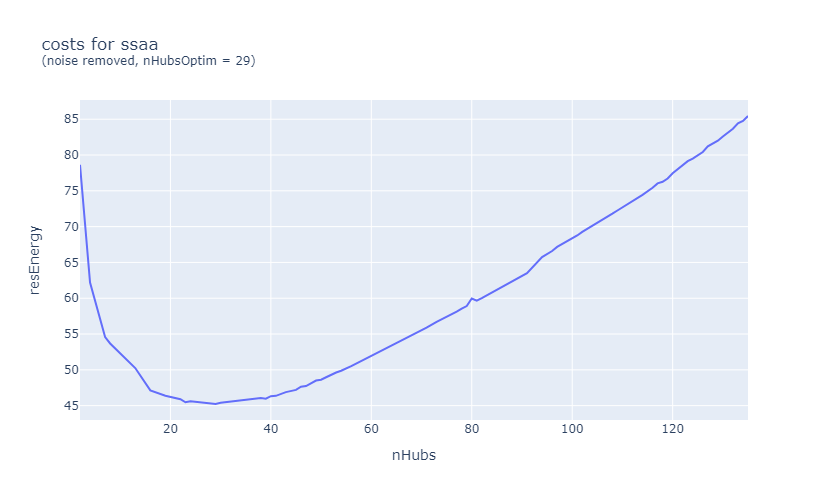

In [26]:
resEnergy = resEnergy_ssaa.copy()
noiseList = [5, 6, 9, 10, 11, 12, 14, 15, 17, 18, 21, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 42, 
            48, 55, 57, 58, 59, 64, 70, 72, 74, 76, 85, 86, 92, 93, 95, 99, 104, 110, 115, 121, 122, 128, 
            98, 103]
resEnergy = resEnergy[~resEnergy.nHubs.isin(noiseList)]

# plot
fig = px.line(resEnergy, 'nHubs', 'resEnergy', width=500, height=500,
                 title='costs for ssaa <br><sup>(noise removed, nHubsOptim = {})</sup>'.format(nHubsOptim_ssaa))
fig.show()

resEnergy.to_csv('forLibby/lineChart_spatialOptimizationCurve.csv')

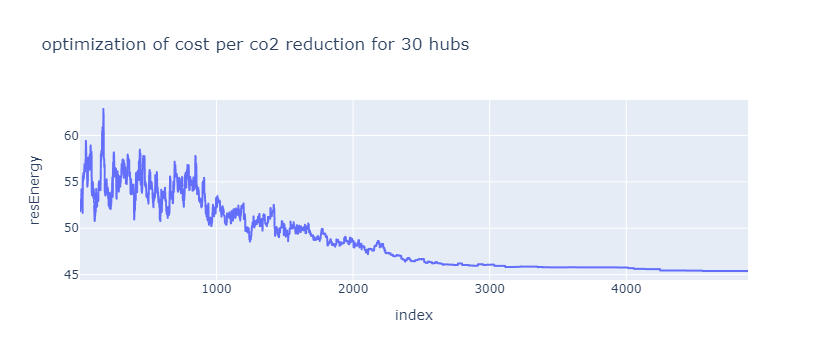

In [28]:
nHubs = 30
temp = resEnergy_ssaa_file[resEnergy_ssaa_file.nHubs == nHubs]
temp.to_csv('forLibby/lineChart_simulatedAnnealingCurve.csv')
px.line(temp, x='index', y='resEnergy', title='optimization of cost per co2 reduction for {} hubs'.format(nHubs))

# gif - simulated annealing

In [40]:
water = gpd.read_file('../_bigData/nlMaps/water_MRA.shp')
waterClipped = gpd.clip(water, streets.geometry.total_bounds)

import imageio.v2 as imageio
images = []
resPointsDfs = []
matDfs = []
serviceAreasDfs = []
for i in range(5): 
    # make geoms 
    resPointsOptim = candiHubs.sample(3)
    matGridAssigned = assignHubsToGridCells(resPointsOptim, matGrid, distMatrix)
    serviceAreas = matGridAssigned.dissolve(by='hubName')
    serviceAreas.geometry = serviceAreas.geometry.convex_hull
    
    # add iternation
    resPointsOptim['iteration'] = i
    matGridAssigned['iteration'] = i
    serviceAreas['iteration'] = i
    
    # add to df list 
    resPointsDfs.append(resPointsOptim)
    matDfs.append(matGridAssigned)
    serviceAreasDfs.append(serviceAreas)
    
dfList_dict = {
    'simulatedAnnealing_hubLocations': resPointsDfs, 
    'simulatedAnnealing_materialLocations': matDfs, 
    'simulatedAnnealing_serviceAreas': serviceAreasDfs
}
shp_dict = {
    'simulatedAnnealing_hubLocations': None, 
    'simulatedAnnealing_materialLocations': None, 
    'simulatedAnnealing_serviceAreas': None
}
    
for name, dfList in dfList_dict.items(): 
    gdf = gpd.GeoDataFrame(pd.concat(dfList))
    print(gdf.head())
    shp_dict[name] = gdf
    gdf.to_file(f'forLibby/{name}.shp')

C:\Users\tpytsui\Miniconda\envs\geo_env\Lib\site-packages\geopandas\tools\clip.py:63: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



    RIN_NUMMER  MAX_MILIEU     pPerSqm  hubName  \
107     706185           3  196.414564      107   
43    27201712           3  252.923727       43   
59        1477           3  267.372412       59   
24      161626           3  779.511822       24   
10      215031           3  291.971767       10   

                          geometry  iteration  
107  POINT (116173.735 495609.640)          0  
43   POINT (120825.914 491363.774)          0  
59   POINT (118032.737 483974.984)          0  
24   POINT (108362.289 502223.871)          1  
10   POINT (139818.183 484096.441)          1  
       kgDemand       kgSupply  hubName                      geometry  \
0  94892.742141       0.000000       59  POINT (98100.000 473500.000)   
1  94892.742141       0.000000       59  POINT (98100.000 473600.000)   
2  55073.559753  143951.923139       59  POINT (98100.000 474400.000)   
3  55073.559753  143951.923139       59  POINT (98100.000 474500.000)   
4      0.000000   44645.254947       59 

In [55]:
water = gpd.read_file('../_bigData/nlMaps/water_MRA.shp')
waterClipped = gpd.clip(water, streets.geometry.total_bounds)
waterClipped.to_file('forLibby/ams_water.shp')
streets = gpd.read_file('data/ams_edges.shp')
streets.to_file('forLibby/ams_streets.shp')
matGrid.to_file('forLibby/materialLocations.shp')

C:\Users\tpytsui\Miniconda\envs\geo_env\Lib\site-packages\geopandas\tools\clip.py:63: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



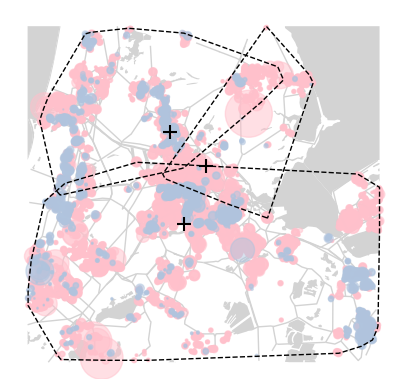

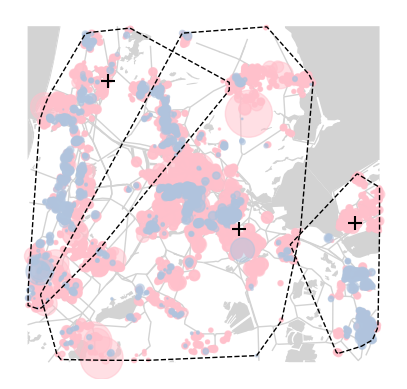

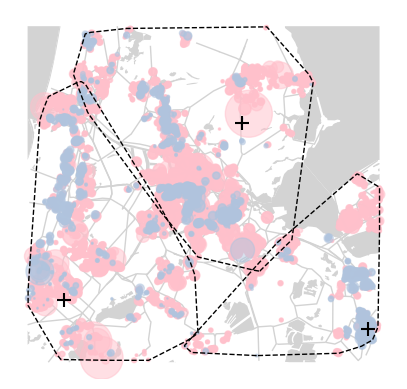

In [53]:
import imageio.v2 as imageio
images = []

hubsGdfs = []
serviceAreasGdfs = []

for i in range(3): 
    fig, ax = plt.subplots(1,1)
        
    matGrid = shp_dict['simulatedAnnealing_materialLocations']
    matGrid = matGrid[matGrid.iteration == i]
    resPointsOptim = shp_dict['simulatedAnnealing_hubLocations']
    resPointsOptim = resPointsOptim[resPointsOptim.iteration == i]
    serviceAreas = shp_dict['simulatedAnnealing_serviceAreas']
    serviceAreas = serviceAreas[serviceAreas.iteration == i]
        
    # plot 
    waterClipped.plot(ax=ax, color='lightgrey')
    streets.plot(color='lightgrey', zorder=-1, linewidth=1, ax=ax)
    matGrid.plot(markersize=matGrid.kgDemand/10000, alpha=0.5, color='pink', ax=ax)
    matGrid.plot(markersize=matGrid.kgSupply/10000, alpha=0.5, color='lightsteelblue', ax=ax)
    resPointsOptim.plot(ax=ax, marker='+', color='black', markersize=100)
    serviceAreas.boundary.plot(ax=ax, color='black', linestyle='dashed', linewidth=1)
    
    # formatting
    ax.axis('off')
    plt.show()
    fig.savefig(f'forLibby/gif/simulatedAnnealing_{i}.png')
    images.append(imageio.imread(f'forLibby/gif/simulatedAnnealing_{i}.png'))
    
imageio.mimsave('forLibby/gif/simulatedAnnealing.gif', images, duration=1000)

# gif = spatial optimization

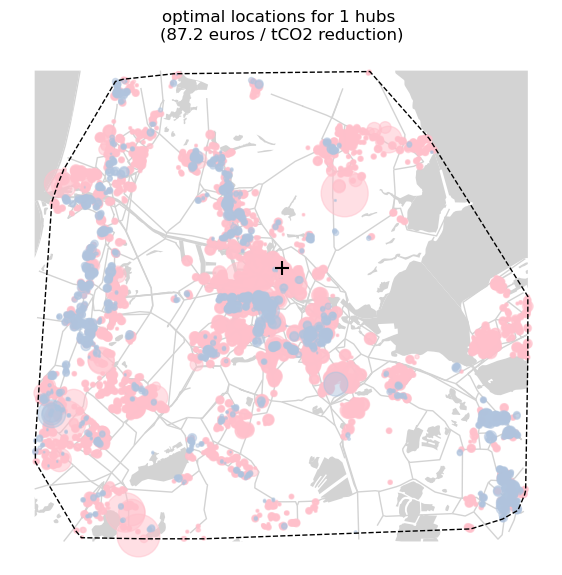

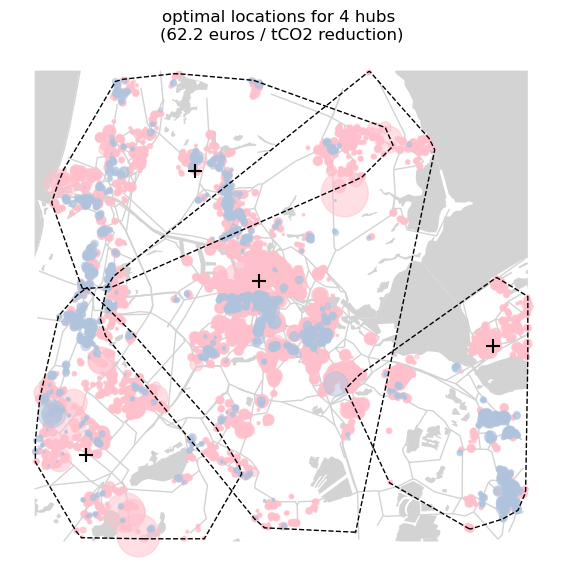

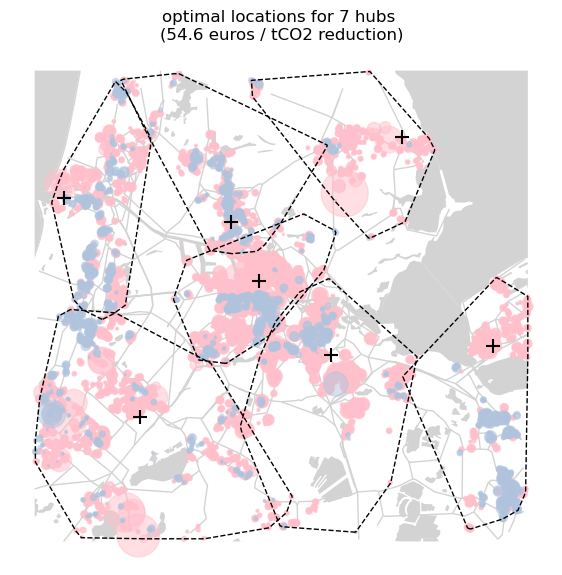

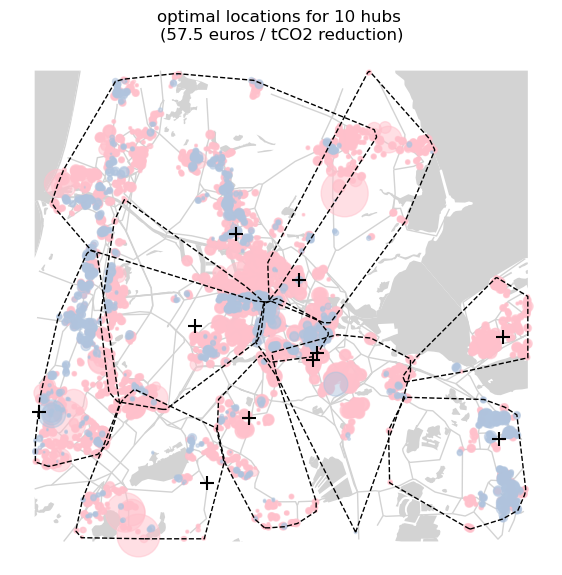

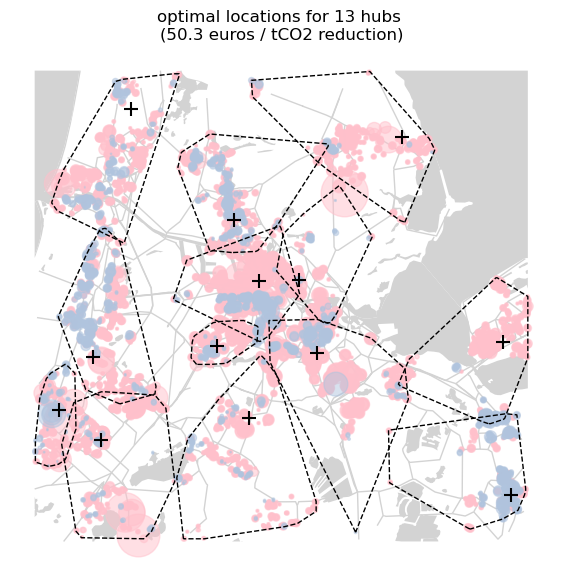

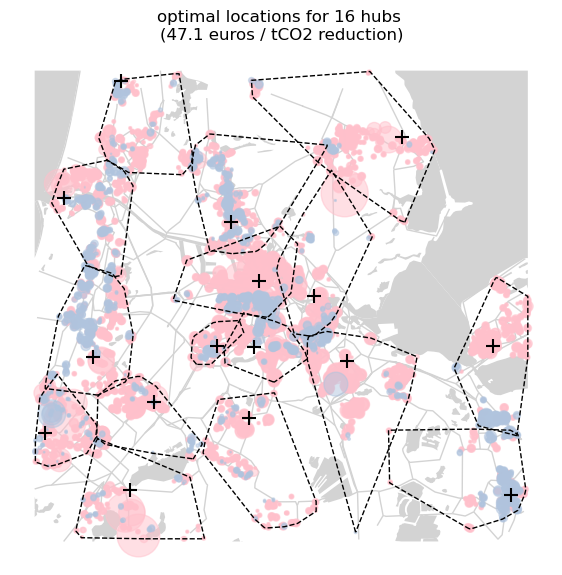

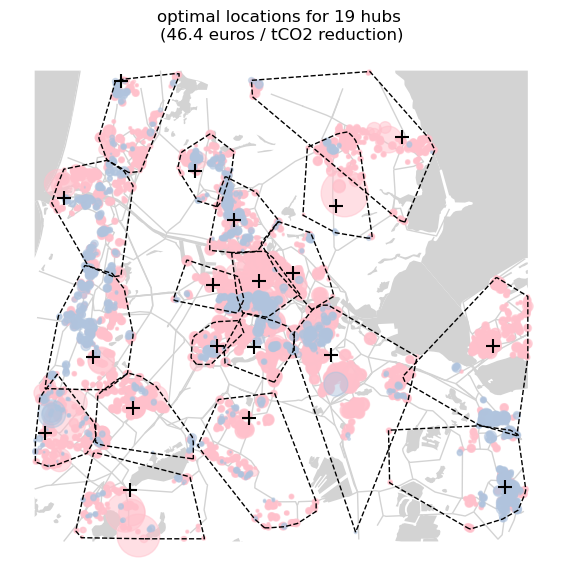

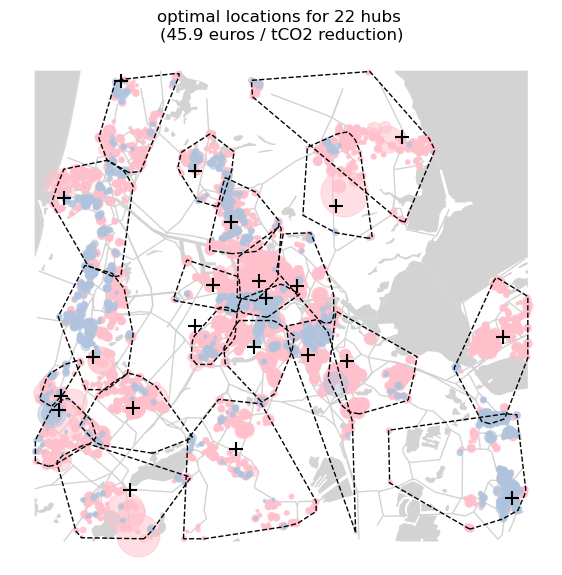

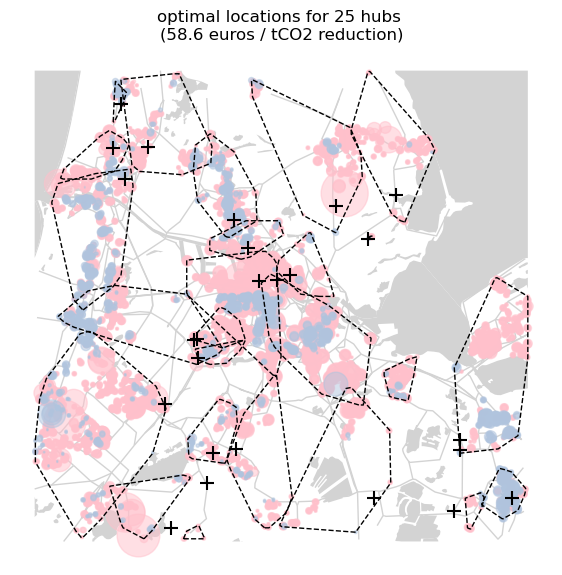

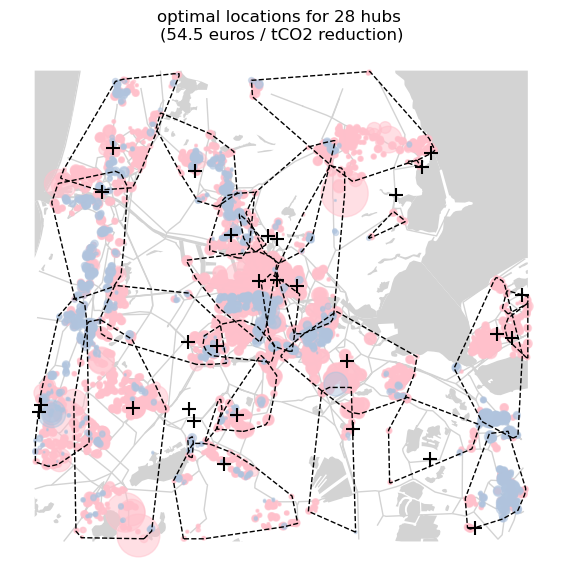

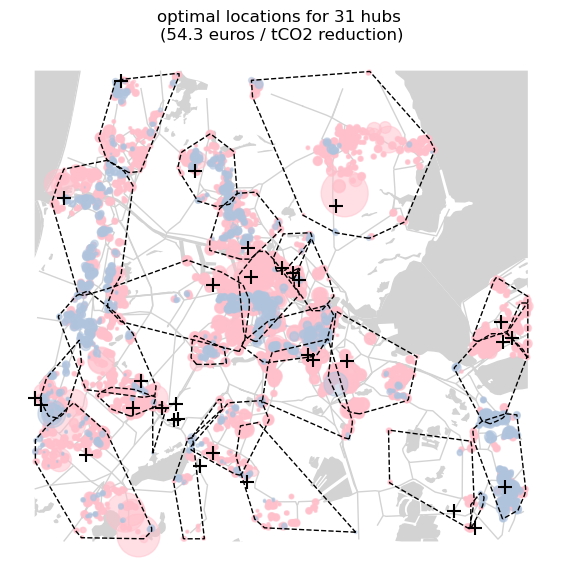

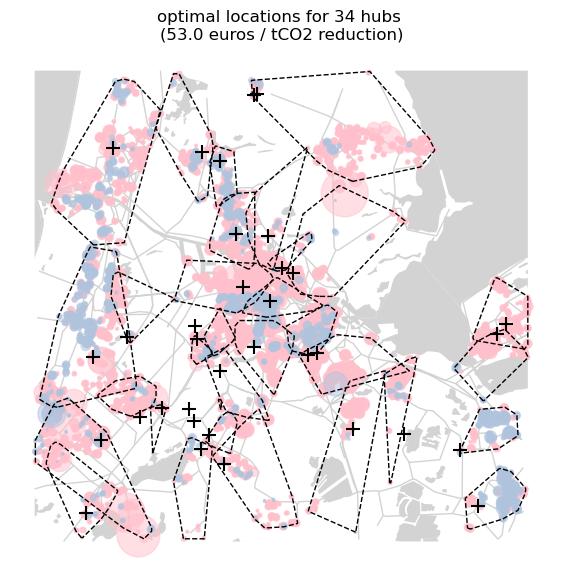

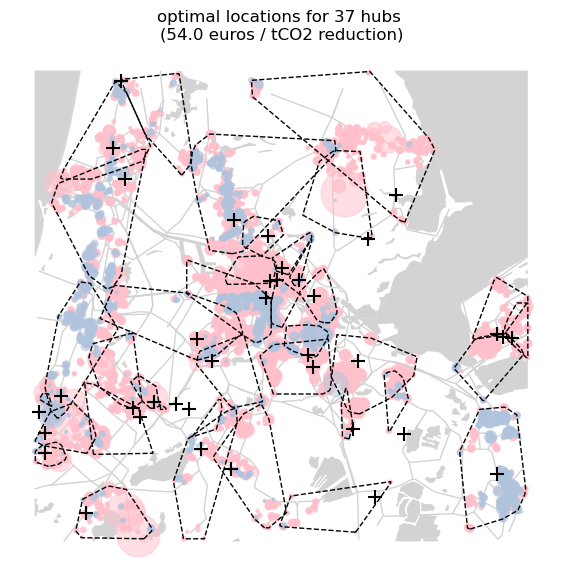

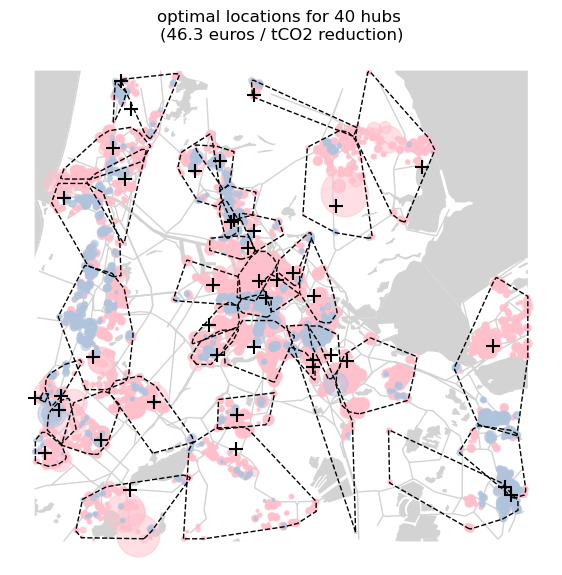

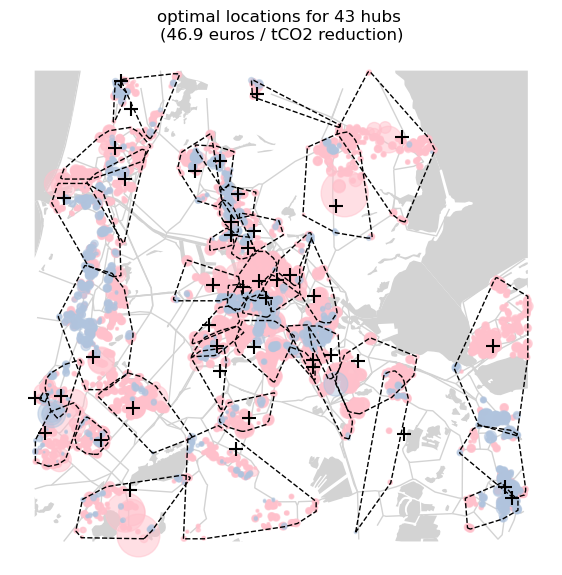

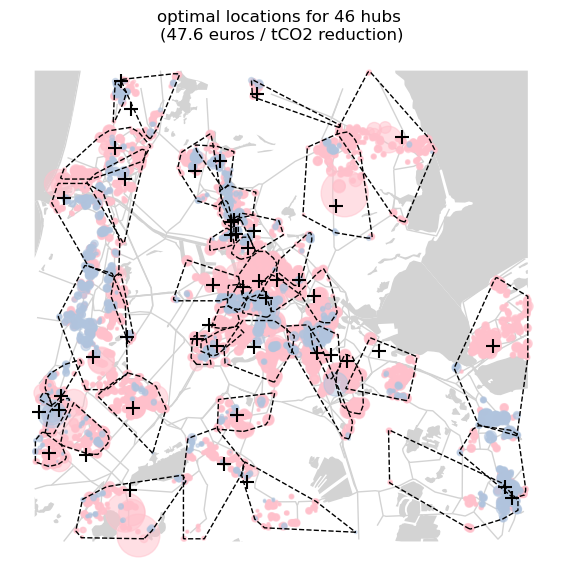

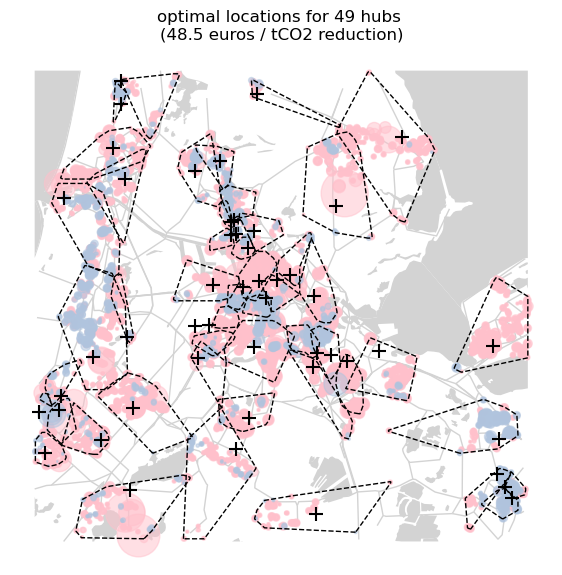

In [56]:
import imageio.v2 as imageio
images = []
hubsGdfs = []
serviceAreasGdfs = []

for nHubs in range(1, 50, 3): 

    fig, ax = plt.subplots(1,1, figsize=(7,8))

    # find resPoints Optim
    if nHubs == 1: 
        resPointsOptim = candiHubs[candiHubs.hubName == 47]
    elif nHubs > 80: 
        resPointsOptim = candiHubs[~candiHubs.hubName.isin(resPoints[resPoints.nHubs == nHubs].hubName)]
    else: 
        resPointsOptim = candiHubs[candiHubs.hubName.isin(resPoints[resPoints.nHubs == nHubs].hubName)]

    # make geoms 
    matGridAssigned = assignHubsToGridCells(resPointsOptim, matGrid, distMatrix)
    serviceAreas = matGridAssigned.dissolve(by='hubName')
    serviceAreas.geometry = serviceAreas.geometry.convex_hull

    # plot 
    waterClipped.plot(ax=ax, color='lightgrey')
    streets.plot(color='lightgrey', zorder=-1, linewidth=1, ax=ax)
    matGrid.plot(markersize=matGrid.kgDemand/10000, alpha=0.5, color='pink', ax=ax)
    matGrid.plot(markersize=matGrid.kgSupply/10000, alpha=0.5, color='lightsteelblue', ax=ax)
    resPointsOptim.plot(ax=ax, marker='+', color='black', markersize=100)
    resPointsOptim['nHubs'] = nHubs
    serviceAreas.boundary.plot(ax=ax, color='black', linestyle='dashed', linewidth=1)
    serviceAreas['nHubs'] = nHubs
    
    hubsGdfs.append(resPointsOptim)
    serviceAreasGdfs.append(serviceAreas)

    # formatting
    if nHubs != 1: 
        resEnergy = round(resEnergy_ssaa[resEnergy_ssaa.nHubs == nHubs].resEnergy.iloc[0], 1)
    else: 
        resEnergy = 87.2
    ax.set_title('optimal locations for {} hubs \n({} euros / tCO2 reduction)'.format(nHubs, resEnergy))
    ax.axis('off')
    plt.show()
    fig.savefig('forLibby/gif/costEffectiveness_{}.png'.format(nHubs))
    images.append(imageio.imread(f'forLibby/gif/costEffectiveness_{nHubs}.png'))
    
imageio.mimsave('forLibby/gif/costEffectiveness.gif', images, duration=1000)

In [67]:
serviceAreas_so = gpd.GeoDataFrame(pd.concat(serviceAreasGdfs))
hubs_so = gpd.GeoDataFrame(pd.concat(hubsGdfs))
serviceAreas_so = serviceAreas_so[serviceAreas_so.geometry.type == 'Polygon']
serviceAreas_so.to_file('forLibby/spatialOptimization_serviceAreas.shp')
hubs_so.to_file('forLibby/spatialOptimization_hubs.shp')

# folium map of important sites for CE

In [15]:
def makeStorageResults(nHubs, ssaa=True): 
    if ssaa: 
        hubs = resPoints[resPoints.nHubs == nHubs]
        if nHubs < 80: 
            hubs = candiHubs[candiHubs.hubName.isin(hubs.hubName)]
        else: 
            hubs = candiHubs[~candiHubs.hubName.isin(hubs.hubName)]
    else: 
        hubs = candiHubs.sample(nHubs)

    matGridAss = assignHubsToGridCells(hubs, matGrid, distMatrix)
    hubs, sc = calcTotStorageCost(hubs, matGridAss, candiHubs, returnHubs=True)
    hubs = hubs[['pPerSqm', 'hubName', 'geometry', 'm2', 
                 'storagePrice', 'storageCost']]
    return hubs

In [16]:
%%time
resPoints_storageStats = pd.DataFrame(columns=['pPerSqm', 'hubName', 'geometry', 
                                               'm2', 'storagePrice', 'storageCost', 
                                               'redundant', 'nHubs'])
for nHubs in resEnergy.nHubs: 
    hubs = makeStorageResults(nHubs, ssaa=True)
    hubs['redundant'] = hubs.m2.map(lambda x: True if x == 300 else False)
    hubs['nHubs'] = nHubs
    resPoints_storageStats = pd.concat([resPoints_storageStats, hubs])
    
resPoints_storageStats

C:\Users\tpytsui\Miniconda\envs\geo_env\Lib\site-packages\geopandas\array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as Amersfoort / RD New (the single non-null crs provided).

<timed exec>:8: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

<timed exec>:8: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

<timed exec>:8: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

<timed exec>:8: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

<timed e

CPU times: total: 1min 36s
Wall time: 1min 37s


<timed exec>:8: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



pPerSqm hubName                       geometry            m2  \
47   252.923727      47  POINT (120604.077 491229.540)  17621.014659   
87   240.898715      87  POINT (112618.668 500073.540)  10169.711036   
107  196.414564     107  POINT (116173.735 495609.640)   6083.686576   
118  252.066723     118  POINT (117014.613 489444.255)  18936.684001   
137  279.247042     137  POINT (106723.743 470972.440)   2770.355118   
..          ...     ...                            ...           ...   
134  265.779341     134  POINT (110501.319 467459.346)    300.000000   
135  186.333125     135  POINT (100415.196 479516.579)    366.927586   
136  287.269338     136   POINT (98973.109 474291.608)    300.000000   
137  279.247042     137  POINT (106723.743 470972.440)    300.000000   
138  291.971767     138  POINT (140736.817 484411.291)    300.000000   

     storagePrice   storageCost redundant nHubs  
47     634.923727  1.118800e+07     False     2  
87     622.898715  6.334700e+06     False     2  
107    578.414564  3.518893e+06     False     3  
118    634.066723  1.200712e+07     False     3  
137    661.247042  1.831889e+06     False     3  
..            ...           ...       ...   ...  
134    647.779341  1.943338e+05      True   135  
135    568.333125  2.085371e+05     False   135  
136    669.269338  2.007808e+05      True   135  
137    661.247042  1.983741e+05      True   135  
138    673.971767  2.021915e+05      True   135  

[6571 rows x 8 columns]

In [18]:
import folium

resPoints_inUse = resPoints_storageStats[resPoints_storageStats.redundant == False]
resPoints_inUse = gpd.GeoDataFrame(resPoints_inUse, crs = 'EPSG:28992')
resPoints_inUse = resPoints_inUse.to_crs('EPSG:4326')

# count number of times hubs are chosen
resPoints_inUse_count = resPoints_inUse
resPoints_inUse_count = resPoints_inUse_count.groupby('hubName').count().geometry.reset_index()
resPoints_inUse_count.rename(columns={'geometry': 'count_'}, inplace=True)
temp = resPoints_inUse[['hubName', 'geometry']].drop_duplicates()
resPoints_inUse_count = resPoints_inUse_count.merge(temp)
resPoints_inUse_count = gpd.GeoDataFrame(resPoints_inUse_count)

# extract hubs that are always redundant
chosenHubs = resPoints_inUse_count.hubName.unique()
resPoints_redundant = resPoints_storageStats[~resPoints_storageStats.hubName.isin(chosenHubs)][['hubName', 'geometry']].drop_duplicates()
resPoints_redundant = gpd.GeoDataFrame(resPoints_redundant, crs='EPSG:28992').to_crs('EPSG:4326')

# map
m = folium.Map(location=[52.37517620709537, 4.898590508328429], tiles="Cartodb dark_matter", zoom_start=10)
for _, row in resPoints_inUse_count.iterrows(): 
    hubName = row.hubName
    count = row.count_
    x = row.geometry.x
    y = row.geometry.y
    
    folium.Circle(
        radius=count*15,
        location=[y,x],
        popup='hub #{}, picked {} times'.format(hubName, count),
        color="crimson",
        fill=True,
    ).add_to(m)
    
for _, row in resPoints_redundant.iterrows():
    hubName = row.hubName
    x = row.geometry.x
    y = row.geometry.y

    folium.Circle(
        radius=10,
        location=[y,x],
        popup='hub #{}, redundant'.format(hubName),
        color="gray",
        fill=True,
    ).add_to(m)
    
m

In [68]:
resPoints_inUse_count.to_file('forLibby/foliumMap_redDots.shp')
resPoints_redundant.to_file('forLibby/foliumMap_greyDots.shp')